### Table of Contents

1. [Preliminaries](#prlm)\
    1.1 [Import packages and data](#impt)\
    1.2 [Visualize the features](#featvis)\
    1.3

<a id='prlm'></a>
# 1. Preliminaries
<a id='impt'></a>
## 1.1 Import packages and data


In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

from scipy import stats
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score, train_test_split
from sklearn.preprocessing  import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [79]:
#import data
train_df=pd.read_csv('../Desktop/train.csv')
test_df=pd.read_csv('../Desktop/test.csv')

#make copy of original data
train_df_orig=train_df.copy()
test_df_orig=test_df.copy()

The labeled training data includes 891 passengers with the following 12 features:

In [80]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [59]:
#show data types
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Numerical features: PassengerId, Survived, Pclass, Age, SibSp, Parch, Fare.\
String features: Name, Sex, Ticket, Cabin, Embarked.

In [60]:
#Some statistics of each column.
train_df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Plotcharsky, Mr. Vasil",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


<a id='featvis'></a>
## 1.2 Visualize the features
We will ignore the PassengerID feature because it very likely has no correlation to survival and we will also ignore Name, Cabin, and Ticket features because I do not have enough information to approach them analytically at this time.  This leaves us with categorical features Pclass, Sex, SibSp, Parch, and Embarked and numerical features Age and Fare. Let's plot the survival rate based on each of these features and determine if it looks like a useful feature.


We can define a function to plot the survived versus deceased rate for each categorical feature.

In [61]:
def survival_plot(df,col,x_vals,x_labels,plot_title,xaxis_title,yaxis_title):    
    df_= df.groupby([col,'Survived']).Name.agg('count').to_frame('Count').reset_index() #create count column by grouping
    df_ = pd.merge(df_,df_.groupby([col])[['Count']].sum(),how='inner',on=[col,]).rename(columns={'Count_x':'Count','Count_y':'Total'}) #add count column back 
    df_=pd.merge(pd.DataFrame({col:x_vals}).merge(pd.DataFrame({'Survived':[0,1]}),how='cross'),df_,how='left',on=[col,'Survived']) #define which x_vals to include (may be more or less than present)
    df_['Percent']=df_['Count']/df_['Total']*100  #add a percent column
    df_survived = df_[df_['Survived']==1].reset_index(drop=True)  #separate the survived and deceased
    df_deceased = df_[df_['Survived']==0].reset_index(drop=True)

    fig = go.Figure()
    fig.add_trace(go.Bar(name='Survived', x=x_labels, y=df_survived['Count'],
                        customdata=df_survived['Percent'],
                        hovertemplate='%{customdata:.2f}%',))
    fig.add_trace(go.Bar(name='Deceased', x=x_labels, y=df_deceased['Count'],
                        customdata=df_deceased['Percent'],
                        hovertemplate='%{customdata:.2f}%',))
    fig.update_layout(
        barmode='stack', 
        title=plot_title, 
        xaxis=dict(title=xaxis_title,titlefont_size=16,tickfont_size=14),
        yaxis=dict(title=yaxis_title,titlefont_size=16,tickfont_size=14)
    )
    fig.show()

### The Ticket Class (Pclass) feature
This feature represents the passenger's ticket class where 1= first class, 2= 2nd class, and 3= third class.  We observe the distribution in our training set.

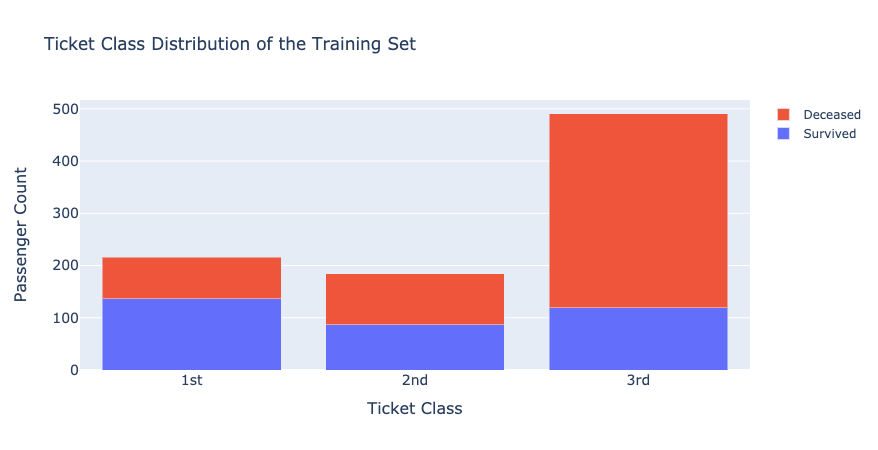

In [81]:
survival_plot(train_df,
                 col='Pclass',
                 x_vals=[1,2,3],
                 x_labels=['1st','2nd','3rd'],
                 plot_title='Ticket Class Distribution of the Training Set',
                 xaxis_title='Ticket Class',
                 yaxis_title='Passenger Count')

Ticket class seems to be a pretty decent indicator of survival.

### The Sex Feature
This feature indicates whether the passenger was male or female.  We suspect women will have a much higher survival rate.

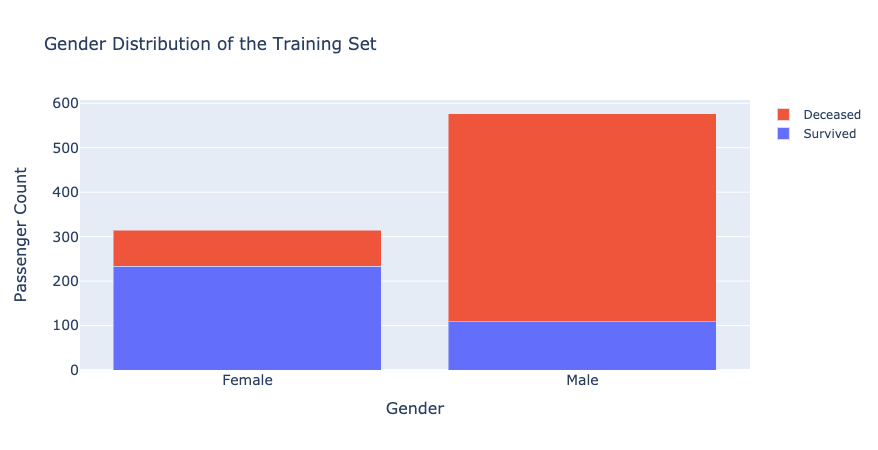

In [25]:
survival_plot(train_df,
                 col='Sex',
                 x_vals=['female','male'],
                 x_labels=['Female','Male'],
                 plot_title='Gender Distribution of the Training Set',
                 xaxis_title='Gender',
                 yaxis_title='Passenger Count')

The sex feature seems like a very good indicator of survival.

### The Sibling/Spouse (SibSp) Feature
This feature counts the number of siblings and/or spouses the passenger is onboard with.

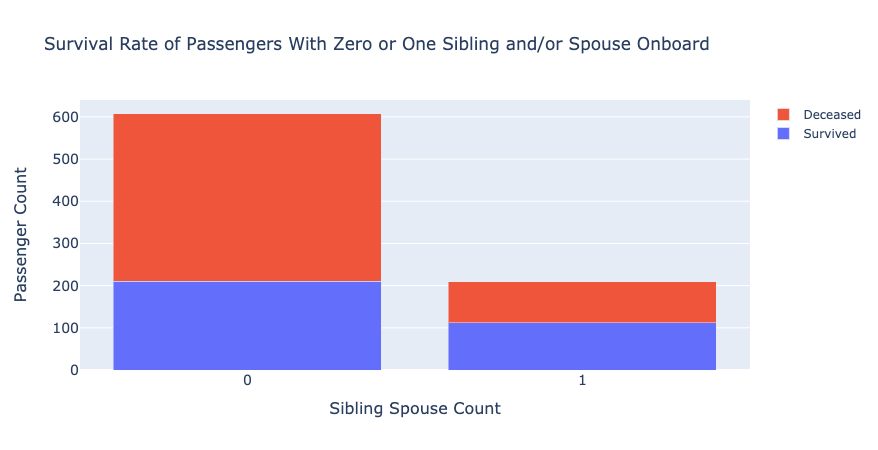

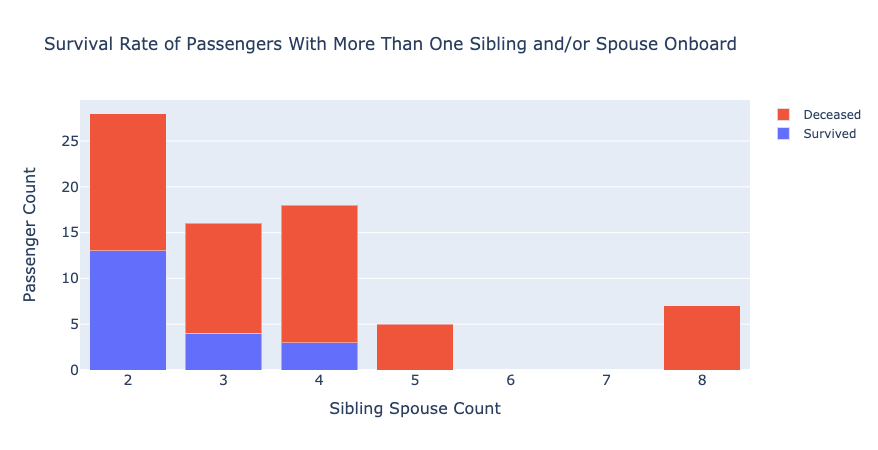

In [26]:
survival_plot(train_df,
                 col='SibSp',
                 x_vals=[0,1],
                 x_labels=['0','1'],
                 plot_title='Survival Rate of Passengers With Zero or One Sibling and/or Spouse Onboard',
                 xaxis_title='Sibling Spouse Count',
                 yaxis_title='Passenger Count')

survival_plot(train_df,
                 col='SibSp',
                 x_vals=[2,3,4,5,6,7,8],
                 x_labels=['2','3','4','5','6','7','8'],
                 plot_title='Survival Rate of Passengers With More Than One Sibling and/or Spouse Onboard',
                 xaxis_title='Sibling Spouse Count',
                 yaxis_title='Passenger Count')

In [27]:
print('Correlation coefficient: ',train_df['Survived'].corr(train_df['SibSp']))


Correlation coefficient:  -0.03532249888573559


This feature looks to be a poor indicator of surival, especially considering that most passengers only have a sibsp count of 0 or 1 where the survival rate is closest to 50%.

### The Parent/Child (Parch) Feature

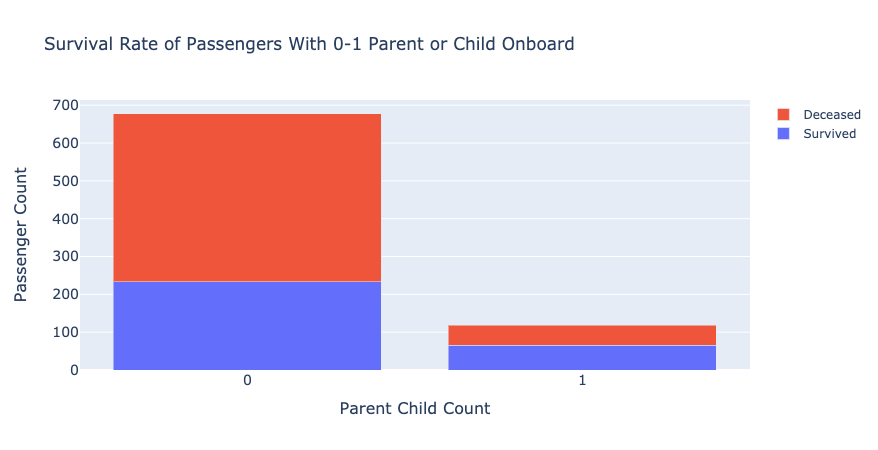

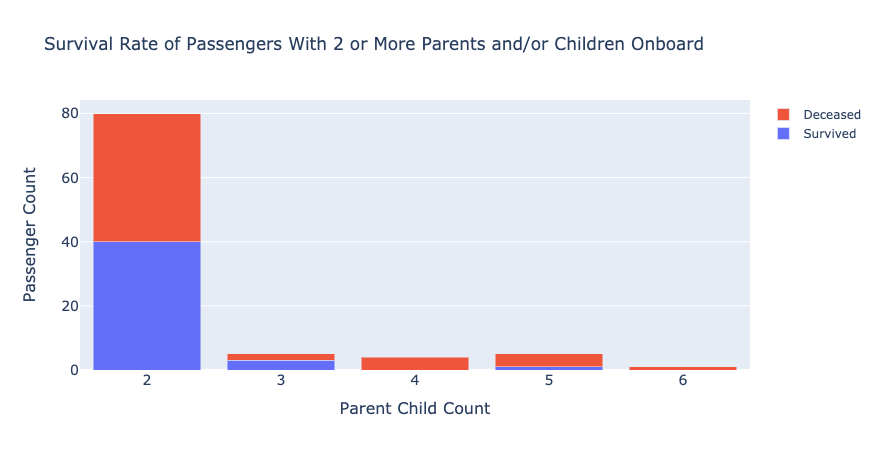

In [31]:
survival_plot(train_df,
                 col='Parch',
                 x_vals=[0,1],
                 x_labels=['0','1'],
                 plot_title='Survival Rate of Passengers With 0-1 Parent or Child Onboard',
                 xaxis_title='Parent Child Count',
                 yaxis_title='Passenger Count')

survival_plot(train_df,
                 col='Parch',
                 x_vals=[2,3,4,5,6],
                 x_labels=['2','3','4','5','6'],
                 plot_title='Survival Rate of Passengers With 2 or More Parents and/or Children Onboard',
                 xaxis_title='Parent Child Count',
                 yaxis_title='Passenger Count')

This features looks to be a poor indicator of survival.

In [32]:
print('Correlation coefficient: ',train_df['Survived'].corr(train_df['Parch']))

Correlation coefficient:  0.08162940708348365


### The Embarked Feature
This feature tells us what port the passenger embarked from, where C = Cherbourg, Q = Queenstown, S = Southampton.

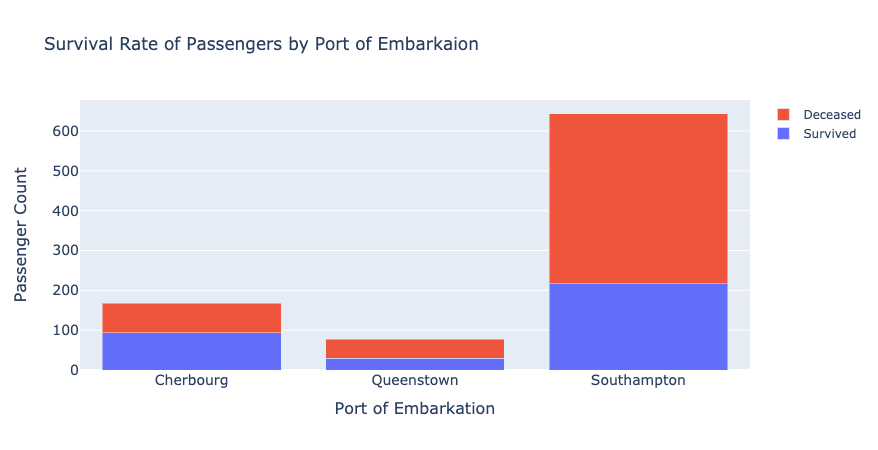

In [33]:
survival_plot(train_df,
                 col='Embarked',
                 x_vals=['C','Q','S'],
                 x_labels=['Cherbourg','Queenstown','Southampton'],
                 plot_title='Survival Rate of Passengers by Port of Embarkaion',
                 xaxis_title='Port of Embarkation',
                 yaxis_title='Passenger Count')

This feature also looks like a poor indicator of survival.

### The Age Feature
The age feature is fractional if less than 1 and the maximum age is 80.

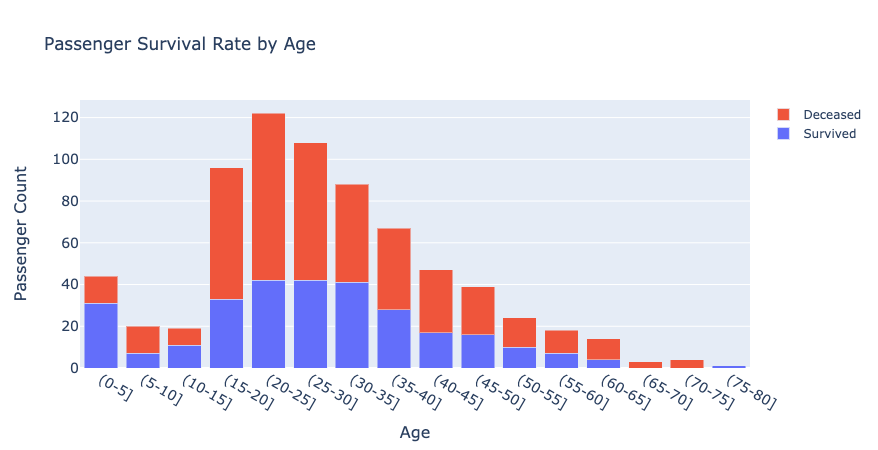

In [82]:
bins=np.linspace(0,80,17)
group_names=['({}-{}]'.format(int(bins[x]),int(bins[x+1])) for x in range(len(bins)-1)]
train_df['Age_cat']=pd.cut(train_df['Age'],bins,labels=group_names,include_lowest=True)

survival_plot(train_df,
                 col='Age_cat',
                 x_vals=group_names,
                 x_labels=group_names,
                 plot_title='Passenger Survival Rate by Age',
                 xaxis_title='Age',
                 yaxis_title='Passenger Count')

It seems like the only age range with a high likelihood of survival is 0-5 years.  Let's make a new binary feature called child which splits the passengers into adult and child.  We can find out exactly which age split will give us the best correlation to survival, since the choice of 0-5 years old above was arbitrary.

In [83]:
child_df=pd.DataFrame()
for x in range(1,18):    
    bins=[0,x,80]
    group_names=[0,1]
    train_df['Child']=pd.cut(train_df['Age'],bins,labels=group_names,include_lowest=True)
    c = train_df['Survived'].corr(train_df['Child'])
    child_df=child_df.append({'Age cut': x,'Corr coeff': c},ignore_index=True)
child_df.sort_values(by='Corr coeff',axis=0).T

,5,4,6,7,14,3,0,8,13,12,9,15,16,11,2,10,1
Age cut,6.000000,5.000000,7.000000,8.000000,15.000000,4.000000,1.000000,9.000000,14.000000,13.000000,10.000000,16.000000,17.000000,12.000000,3.000000,11.000000,2.000000
Corr coeff,-0.159972,-0.155697,-0.153007,-0.151725,-0.136028,-0.133354,-0.129864,-0.129812,-0.126191,-0.125435,-0.119854,-0.118196,-0.118011,-0.115579,-0.111087,-0.110567,-0.083103


So it appears that cutting the ages at 6 years gives us the best correlation coefficient.  We will now finalize this cut.

In [86]:
bins=[0,6,80]
group_names=[0,1]
train_df['Child']=pd.cut(train_df['Age'],bins,labels=group_names,include_lowest=True)
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_cat,Child
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,(20-25],1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,(35-40],1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,(25-30],1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,(30-35],1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,(30-35],1
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,NaN,NaN
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,(50-55],1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,(0-5],0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,(25-30],1
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,(10-15],1


Now we have a new feature called Child.  We can try our classifier using Age and compare this to using Child.

### The Fare Feature
The fare listed seems a bit high for some passengers.  We notice that it's not fare per person, but fare of the total ticket which may include paying for multiple passengers.  When we sort the dataframe by the ticket number this is evident.

In [87]:
train_df[['PassengerId','Survived','Ticket','Fare']].sort_values(by='Ticket',axis=0).head(8)

,PassengerId,Survived,Ticket,Fare
504,505,1,110152,86.50
257,258,1,110152,86.50
759,760,1,110152,86.50
262,263,0,110413,79.65
558,559,1,110413,79.65
585,586,1,110413,79.65
110,111,0,110465,52.00
475,476,0,110465,52.00


So now we can count how many passengers are on each ticket and adjust our fare column to represent fare per passenger rather than per ticket.  We see that the maximum fare goes from around 500 to around 200 dollars.

In [89]:
train_df_updated=train_df.join(train_df.groupby('Ticket')['Fare'].count(),on='Ticket', rsuffix=' count')
train_df_updated['Fare']=train_df_updated['Fare']/train_df_updated['Fare count']
train_df_updated.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_cat,Child,Fare count
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,(20-25],1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,(35-40],1,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,(25-30],1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,26.5500,C123,S,(30-35],1,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,(30-35],1,1


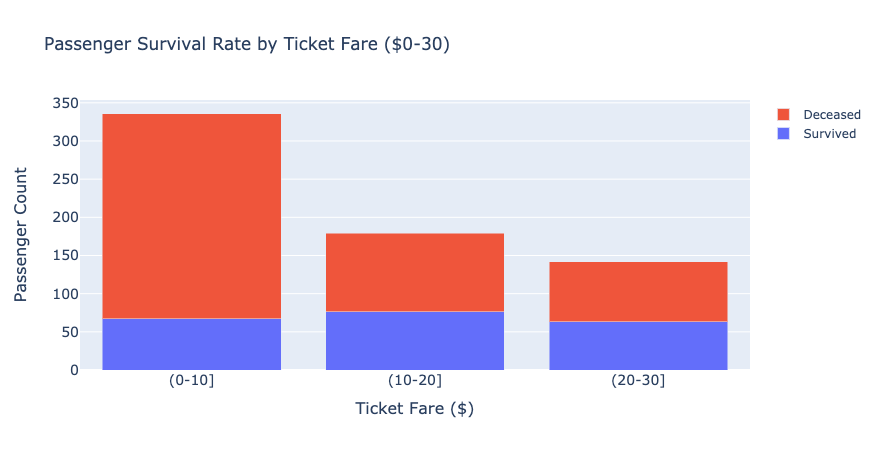

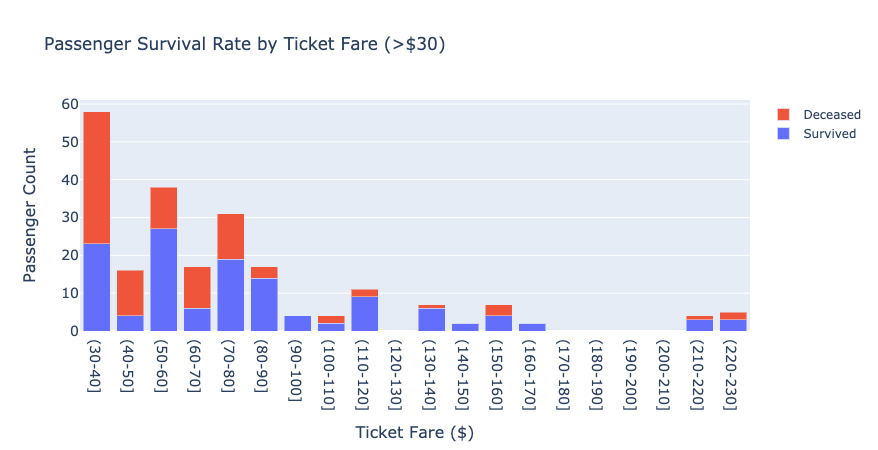

In [90]:
bins=np.linspace(0,230,24)
group_names=['({}-{}]'.format(int(bins[x]),int(bins[x+1])) for x in range(len(bins)-1)]
train_df_updated['Fare_cat']=pd.cut(train_df['Fare'],bins,labels=group_names,include_lowest=True)

survival_plot(train_df_updated,
                 col='Fare_cat',
                 x_vals=group_names[:3],
                 x_labels=group_names[:3],
                 plot_title='Passenger Survival Rate by Ticket Fare ($0-30)',
                 xaxis_title='Ticket Fare ($)',
                 yaxis_title='Passenger Count')

survival_plot(train_df_updated,
                 col='Fare_cat',
                 x_vals=group_names[3:],
                 x_labels=group_names[3:],
                 plot_title='Passenger Survival Rate by Ticket Fare (>$30)',
                 xaxis_title='Ticket Fare ($)',
                 yaxis_title='Passenger Count')

This feature looks to be a pretty good indicator of survival.

In [91]:
print('Correlation coefficient: ',train_df_updated['Survived'].corr(train_df_updated['Fare']))

Correlation coefficient:  0.254824108533421


### Visualization conclusions: 
So we've decided to include as features for our classifier: Pclass, Sex, Age, Child, and Fare.

## Missing Values
We can see that we are missing 177 Age/Child values. We aren't going to be using Cabin or Embarked values so we don't have to worry about those.

In [92]:
#Find the number of null values in each column
train_df_updated.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Age_cat        177
Child          177
Fare count       0
Fare_cat        11
dtype: int64

### Using the Name feature to infer age

The title of each passenger, as in Mr., Mrs, etc. may hold useful information about the passenger's age.  This can help us approximate the 177 unknown ages.  We will extract the title from each passenger's name, where we define a title as all text that comes before the first period followed by a space if there is one.

In [93]:
train_df_updated['Title']=''
for pid,name in zip(train_df_updated['PassengerId'].to_list(),train_df_updated['Name'].to_list()):
    try:
        name_title = re.search('\s[a-zA-Z]+\.', name).group()
    except AttributeError:
        name_title = np.nan
    train_df_updated.loc[pid-1,'Title']=name_title

In [95]:
train_df_updated

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_cat,Child,Fare count,Fare_cat,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,(20-25],1,1,(0-10],Mr.
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,(35-40],1,1,(70-80],Mrs.
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,(25-30],1,1,(0-10],Miss.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,26.5500,C123,S,(30-35],1,2,(50-60],Mrs.
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,(30-35],1,1,(0-10],Mr.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,(25-30],1,1,(10-20],Rev.
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,(15-20],1,1,(20-30],Miss.
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,11.7250,NaN,S,NaN,NaN,2,(20-30],Miss.
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,(25-30],1,1,(20-30],Mr.


Let's look at the age distribution associated with each name title.

In [96]:
train_df_updated.groupby('Title')[['Age']].count().join(
    train_df_updated.groupby('Title')[['Age']].mean().join(
        train_df_updated.groupby('Title')[['Age']].std(), on='Title', lsuffix=' mean', rsuffix=' std'),on='Title').rename(columns={'Age':'Age Count'})

,Age Count,Age mean,Age std
Title,,,
Capt.,1,70.000000,NaN
Col.,2,58.000000,2.828427
Countess.,1,33.000000,NaN
Don.,1,40.000000,NaN
Dr.,6,42.000000,12.016655
Jonkheer.,1,38.000000,NaN
Lady.,1,48.000000,NaN
Major.,2,48.500000,4.949747
Master.,36,4.574167,3.619872


Based on the age distribution associated with each name title, we will assume every Master with no listed age is a child otherwise, they are an adult.

In [111]:
train_df_updated.loc[train_df_updated.Age.isnull(),'Child'].loc[train_df_updated.Title==' Master.']=0
train_df_updated.loc[train_df_updated.Age.isnull(),'Child'].loc[train_df_updated.Title!=' Master.']=1
train_df_updated[['Age','Child','Title']].loc[train_df_updated.Age.isnull()].head(20)

,Age,Child,Title
5,NaN,NaN,Mr.
17,NaN,NaN,Mr.
19,NaN,NaN,Mrs.
26,NaN,NaN,Mr.
28,NaN,NaN,Miss.
29,NaN,NaN,Mr.
31,NaN,NaN,Mrs.
32,NaN,NaN,Miss.
36,NaN,NaN,Mr.
42,NaN,NaN,Mr.


In [99]:
train_df_updated

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_cat,Child,Fare count,Fare_cat,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,(20-25],1,1,(0-10],Mr.
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,(35-40],1,1,(70-80],Mrs.
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,(25-30],1,1,(0-10],Miss.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,26.5500,C123,S,(30-35],1,2,(50-60],Mrs.
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,(30-35],1,1,(0-10],Mr.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,(25-30],1,1,(10-20],Rev.
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,(15-20],1,1,(20-30],Miss.
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,11.7250,NaN,S,NaN,NaN,2,(20-30],Miss.
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,(25-30],1,1,(20-30],Mr.


# Prepare the Data for a Decision Tree Model

Next we split our training data into train and test data so we can evaluate our model's accuracy.

In [46]:
train_set=train_df
test_set=test_df

#Make all columns lowercase
train_set.columns=[x.lower() for x in train_df.columns]
test_set.columns=[x.lower() for x in test_df.columns]

#split the feature and target sets
X_set = train_set[['pclass','sex','age','sibsp','parch','fare','embarked']]
y_set = train_set['survived']
test_set  = test_set[['pclass','sex','age','sibsp','parch','fare','embarked']]

#make dummy columns for categorical values
for col in ['pclass','sex','sibsp','parch','embarked']:
    X_set=pd.concat([X_set,pd.get_dummies(X_set[col],prefix = col,dtype=int)],axis=1)
    del X_set[col]
    test_set=pd.concat([test_set,pd.get_dummies(test_set[col],prefix = col,dtype=int)],axis=1)
    del test_set[col]
    
#make sure dummy columns match for training and test set
df=pd.concat([X_set,test_set],axis=0)
X_set=df.iloc[:len(X_set)]
test_set=df.iloc[len(X_set):]


In [47]:
X_set.shape

(891, 25)

In [48]:
test_set.shape

(418, 25)

In [49]:
X_set.columns

Index(['age', 'fare', 'pclass_1', 'pclass_2', 'pclass_3', 'sex_female',
       'sex_male', 'sibsp_0', 'sibsp_1', 'sibsp_2', 'sibsp_3', 'sibsp_4',
       'sibsp_5', 'sibsp_8', 'parch_0', 'parch_1', 'parch_2', 'parch_3',
       'parch_4', 'parch_5', 'parch_6', 'embarked_C', 'embarked_Q',
       'embarked_S', 'parch_9'],
      dtype='object')

In [50]:
test_set.columns

Index(['age', 'fare', 'pclass_1', 'pclass_2', 'pclass_3', 'sex_female',
       'sex_male', 'sibsp_0', 'sibsp_1', 'sibsp_2', 'sibsp_3', 'sibsp_4',
       'sibsp_5', 'sibsp_8', 'parch_0', 'parch_1', 'parch_2', 'parch_3',
       'parch_4', 'parch_5', 'parch_6', 'embarked_C', 'embarked_Q',
       'embarked_S', 'parch_9'],
      dtype='object')

**Null Values**

In [51]:
#find median age for all passengers
median = df['age'].median()
#replace null age values with median
X_set['age']=X_set['age'].replace(np.nan,median)
test_set['age']=test_set['age'].replace(np.nan,median)

#find median fare for all passengers
median = df['fare'].median()
#replace null fare values with median
X_set['fare']=X_set['fare'].replace(np.nan,median)
test_set['fare']=test_set['fare'].replace(np.nan,median)

#replace dummy variable null values with 0
X_set=X_set.replace(np.nan,0)

<ipython-input-51-4952fef9dd94>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-51-4952fef9dd94>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-51-4952fef9dd94>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-51-4952fe

In [52]:
X_set.isnull().values.any()

False

**Scale and fit the data**

In [53]:
for data in [X_set,test_set]:
    # scaling  our numeric columns
    std = StandardScaler()
    for col in ['age','fare']:
        data[col] = pd.Series(std.fit_transform(data[col].values.reshape(-1,1)).reshape(-1))

<ipython-input-53-0b2ed1408feb>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-53-0b2ed1408feb>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#Define all the classification models to compare
# define models to test:
base_models = [("SVM",      SVC()),                                                               #Support Vector Machines
               ("kNN",      KNeighborsClassifier(n_neighbors = 3)),                               #KNeighborsClassifier
               ("LR_model", LogisticRegression(random_state=42,n_jobs=-1)),                       #Logistic Regression model
               ("DT_model", DecisionTreeClassifier(random_state=42)),                             #Decision tree model
               ("RF_model", RandomForestClassifier(random_state=42, n_jobs=-1))]

# Use cross validation and compare the models

In [ ]:
#Partition data into 5 folds for cross validation
kfolds = 5 
split = StratifiedKFold(n_splits=kfolds,
                        shuffle=True, 
                        random_state=42)  

#Loop through all the classification models and output their scores
models_data = {'min_score':{},'max_score':{},'mean_score':{},'std_dev':{}}
for name, model in base_models:
    # get cross validation score for each model:
    cv_results = cross_val_score(model, 
                                 X_set, y_set, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
    
    # output:
    #To find the average of all the accuracies.
    min_score = round(min(cv_results)*100, 4)
    models_data['min_score'][name] = min_score
     
    #To find the max accuracy of all the accuracies.
    max_score = round(max(cv_results)*100, 4)
    models_data['max_score'][name] = max_score
    
    #To find the min accuracy of all the accuracies.
    mean_score = round(np.mean(cv_results)*100, 4)
    models_data['mean_score'][name] = mean_score
    
    # let's find the standard deviation of the data to see degree of variance in the results obtained by our model.
    std_dev = round(np.std(cv_results), 4)
    models_data['std_dev'][name] = std_dev
    
    print(f"{name} cross validation accuarcy score: {mean_score} +/- {std_dev} (std) ---> min: {min_score}, max: {max_score}")

In [ ]:
models_df = pd.DataFrame(models_data).sort_values(by='mean_score',ascending=False)
models_df

**Train the SVM model on all our training data**

In [ ]:
Y_pred = base_models[0][1].fit(X_set, y_set).predict(test_set)


In [ ]:
Y_pred

In [ ]:
submission = pd.DataFrame({
        "PassengerId": test_df['passengerid'],
        "Survived": Y_pred
    })
submission.to_csv('submission.csv', index=False)